# Imports

In [1]:
import sys
import os
import torch
import random
import numpy as np
import torch.nn as nn
import os.path as osp
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.metrics import f1_score, confusion_matrix

from types import SimpleNamespace
from typing import Iterable, List
from torch.utils.data import Dataset, DataLoader

from ablkit.bridge import SimpleBridge
from ablkit.learning import ABLModel, BasicNN
from ablkit.reasoning import KBBase, Reasoner
from ablkit.utils import ABLLogger, print_log
from ablkit.data.evaluation import BaseMetric
from ablkit.data.evaluation import ReasoningMetric, SymbolAccuracy

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.append(os.path.abspath(".."))       
sys.path.append(os.path.abspath("../.."))    
sys.path.append(os.path.abspath("../../..")) 

from utils import fprint
from utils.train import compute_coverage
from utils.status import progress_bar

from datasets import get_dataset

from argparse import Namespace

from backbones.base.ops import *

from protonet_mnist_add_modules.utility_modules.proto_utils import init_dataloader
from protonet_mnist_add_modules.data_modules.proto_data_creation import (
    choose_initial_prototypes,
    get_augmented_support_query_set,
)

print(sys.path)

['/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist/notebooks', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python38.zip', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/lib-dynload', '', '/users-1/eleonora/.local/lib/python3.8/site-packages', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/mnist', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation', '/users-1/eleonora/reasoning-shortcuts/IXShort', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/problog/lib/python3/linux', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/problog/lib/python3', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/problog/lib', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages/problog/tasks/../..']


# Utils

In [2]:
def plot_training_image(images, labels, plot_index_start=0, plot_index_end=10):
    for plotting_index in range(plot_index_start, plot_index_end + 1):
        image = images[plotting_index].cpu().numpy().transpose(1, 2, 0)
        plt.figure(figsize=(5, 5))
        plt.imshow(image, cmap='gray')
        plt.title(f"Label {labels[plotting_index]}")
        plt.axis('off')
        plt.show()

In [3]:
def merge_mnist_pairs(images, labels):
    assert images.ndim == 4 and images.shape[1:] == (1, 28, 28), \
        f"Expected image shape (N, 1, 28, 28), got {images.shape}"
    assert labels.ndim == 2 and labels.shape[1] == 1, \
        f"Expected label shape (N, 1), got {labels.shape}"

    N = images.size(0)
    if N % 2 != 0:
        images = images[:-1]
        labels = labels[:-1]
        N -= 1

    merged_images = torch.cat([images[0::2], images[1::2]], dim=3)
    flat_labels = labels.squeeze(1)
    concepts = torch.stack([flat_labels[0::2], flat_labels[1::2]], dim=1)
    labels = concepts.sum(dim=1)

    return merged_images, concepts, labels

# Working with the Data

## Unsupervised Data Loading

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
Using Dataset:  <datasets.shortcutmnist.SHORTMNIST object at 0x7f49a8260c70>
Loading train data
Loading val data
Loading test data
6000 5040 6000 (6000,)
6000 420 6000 (6000,)


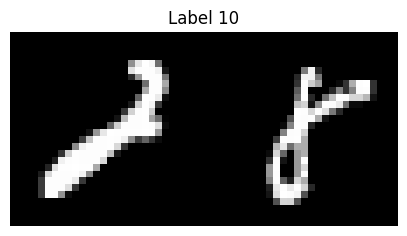

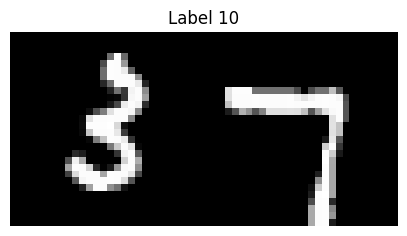

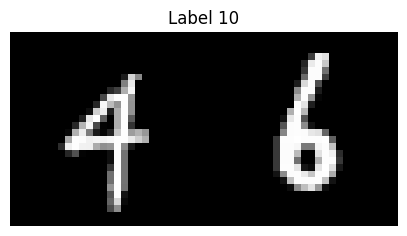

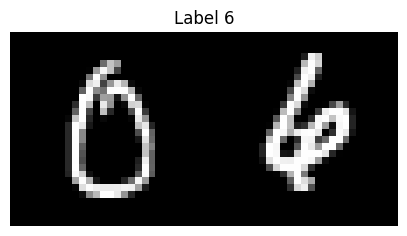

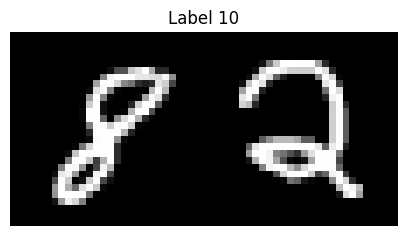

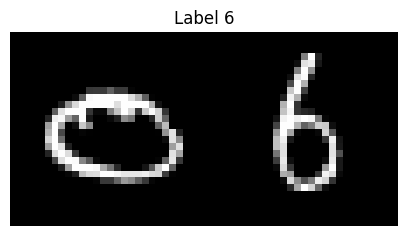

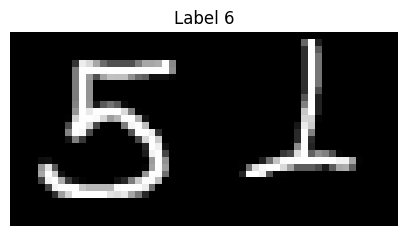

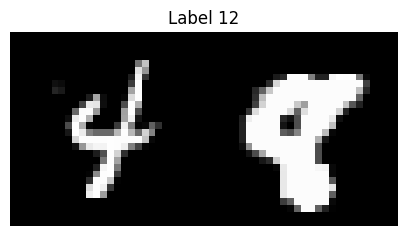

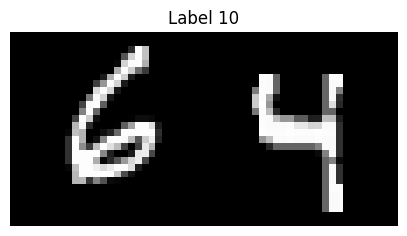

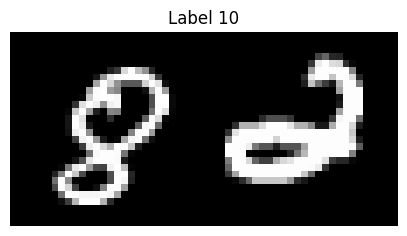

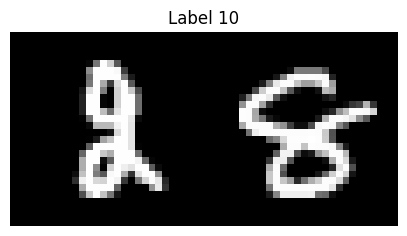

In [4]:

# ^ arguments to load the shortmnist dataset
args_short = Namespace(
    dataset='shortmnist',     
    batch_size=32,
    preprocess=0,
    c_sup=0,
    which_c=[-1],
    model='mnistsl',        
    task='addition',
    lr=0.001,
    weight_decay=0.0001, 
)

dataset = get_dataset(args_short)
print("Using Dataset: ", dataset)
unsup_train_loader, unsup_val_loader, unsup_test_loader = dataset.get_data_loaders()
for i, data in enumerate(unsup_train_loader):
    images, labels, concepts = data        
    plot_training_image(images, labels)
    break

## Supervisions Loading

In [5]:

# ^ dataset to load the supervisions for pretraining
class MNISTAugDataset(Dataset):
    def __init__(self, images, labels, hide_labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label.squeeze()

    def __len__(self):
        return len(self.labels)
    

# ^ dataset to load the supervisions during training
class MNISTAugDatasetTraining(Dataset):
    def __init__(self, images, labels, concepts):
        self.images = images
        self.labels = labels
        self.concepts = concepts

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        concept = self.concepts[index]
        return image, label, concept

    def __len__(self):
        return len(self.labels)

In [6]:

# ^ arguments to load the supervisions
args_add = Namespace( 
    dataset='addmnist',     
    batch_size=32,
    preprocess=0,
    c_sup=1,
    which_c=[-1],
    model='mnistsl',        
    task='addition',    
)

addmnist_dataset = get_dataset(args_add)
addmnist_train_loader, _ , _ = addmnist_dataset.get_data_loaders()
print(addmnist_dataset)

if ( (not os.path.exists('data/prototypes/proto_loader_dataset.pth')) ):
    print("Creating proto_loader_dataset.pth")
    choose_initial_prototypes(addmnist_train_loader, debug=False)

tr_dataloader = init_dataloader()
support_images_aug, support_labels_aug, _, _, _ = get_augmented_support_query_set(tr_dataloader, debug=False)

assert support_images_aug.numel() > 0, "support_images_aug is an empty tensor"
assert support_labels_aug.numel() > 0, "support_labels_aug is an empty tensor"
assert not torch.all(support_images_aug == 0), "All elements in support_images_aug are zero"
assert not torch.all(support_labels_aug == 0), "All elements in support_labels_aug are zero"

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
Loading train data
Loading val data
Loading test data
Number of rotations:  400
Number of translations:  1440
Number of scalings:  100
Number of elastic transformations:  250
Number of noising transformations:  40


In [7]:

# ^ create the PyTorch DataLoader for the supervisions
mnist_dataset = MNISTAugDataset(support_images_aug, support_labels_aug)
sup_train_loader = DataLoader(mnist_dataset, batch_size=32, shuffle=True)

merged_images, concepts, labels = merge_mnist_pairs(support_images_aug, support_labels_aug)
mnist_dataset = MNISTAugDatasetTraining(merged_images, labels, concepts)
sup_train_loader_training = DataLoader(mnist_dataset, batch_size=32, shuffle=True)

## Convert the Unsupervised Data to ABL-ready format

In [8]:
def dataloader_to_list(dataloader):
    X_list, gt_pseudo_list, Y_list = [], [], []
    for batch in dataloader:
        images, labels, concepts = batch
        batch_size = images.shape[0]
        assert images.shape == torch.Size([batch_size, 1, 28, 56]), \
            f"Expected tensor shape [{batch_size}, 1, 28, 56], got {images.shape}"
        assert labels.shape == torch.Size([batch_size]), \
            f"Expected tensor shape [{batch_size}], got {labels.shape}"
        assert concepts.shape == torch.Size([batch_size, 2]), \
            f"Expected tensor shape [{batch_size}, 2], got {concepts.shape}"
        
        left_digits = images[:, :, :, :28]
        right_digits = images[:, :, :, 28:]

        for i in range(batch_size):
            X_list.append([left_digits[i], right_digits[i]])
            gt_pseudo_list.append(concepts[i].tolist())
            Y_list.append(labels[i].item())
            
    return X_list, gt_pseudo_list, Y_list


abl_unsup_train_data = dataloader_to_list(unsup_train_loader)
abl_unsup_val_data   = dataloader_to_list(unsup_val_loader)
abl_unsup_test_data  = dataloader_to_list(unsup_test_loader)
abl_sup_train_data   = dataloader_to_list(sup_train_loader_training)

In [11]:
print(f"Both train_data and test_data consist of 3 components: X, gt_pseudo_label, Y")
print()
train_X, train_gt_pseudo_label, train_Y = abl_unsup_train_data
print(
    f"Length of X, gt_pseudo_label, Y in train_data: "
    + f"{len(train_X)}, {len(train_gt_pseudo_label)}, {len(train_Y)}"
)
test_X, test_gt_pseudo_label, test_Y = abl_unsup_val_data
print(
    f"Length of X, gt_pseudo_label, Y in test_data: "
    + f"{len(test_X)}, {len(test_gt_pseudo_label)}, {len(test_Y)}"
)
print()

X_0, gt_pseudo_label_0, Y_0 = train_X[0], train_gt_pseudo_label[0], train_Y[0]
print(
    f"X is a {type(train_X).__name__}, "
    + f"with each element being a {type(X_0).__name__} "
    + f"of {len(X_0)} {type(X_0[0]).__name__} whose shape is {X_0[0].shape}."
)
print(
    f"gt_pseudo_label is a {type(train_gt_pseudo_label).__name__}, "
    + f"with each element being a {type(gt_pseudo_label_0).__name__} "
    + f"of {len(gt_pseudo_label_0)} {type(gt_pseudo_label_0[0]).__name__}."
)
print(f"Y is a {type(train_Y).__name__}, " + f"with each element being an {type(Y_0).__name__}.")

Both train_data and test_data consist of 3 components: X, gt_pseudo_label, Y

Length of X, gt_pseudo_label, Y in train_data: 6720, 6720, 6720
Length of X, gt_pseudo_label, Y in test_data: 1920, 1920, 1920

X is a list, with each element being a list of 2 Tensor whose shape is torch.Size([1, 28, 28]).
gt_pseudo_label is a list, with each element being a list of 2 int.
Y is a list, with each element being an int.


## Check the Unsupervised Data 

In [ ]:
X_0, gt_pseudo_label_0, Y_0 = train_X[0], train_gt_pseudo_label[0], train_Y[0]
print(f"X in the first data example (a list of two images):")
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(X_0[0].squeeze(), cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(X_0[1].squeeze(), cmap="gray")
plt.show()
print(
    f"gt_pseudo_label in the first data example (a list of two ground truth pseudo-labels): {gt_pseudo_label_0}"
)
print(f"Y in the first data example (their sum result): {Y_0}")

# Building the Learning Part

*Define the backbone*

In [ ]:
class MNISTSingleEncoder(nn.Module):
    def __init__(
        self, img_channels=1, hidden_channels=32, c_dim=10, latent_dim=16, dropout=0.5
    ):
        super(MNISTSingleEncoder, self).__init__()

        self.channels = 3
        self.img_channels = img_channels
        self.hidden_channels = hidden_channels
        self.c_dim = c_dim
        self.latent_dim = latent_dim

        self.unflatten_dim = (3, 7)

        self.enc_block_1 = nn.Conv2d(
            in_channels=self.img_channels,
            out_channels=self.hidden_channels,
            kernel_size=4,
            stride=2,
            padding=1,
        )

        self.enc_block_2 = nn.Conv2d(
            in_channels=self.hidden_channels,
            out_channels=self.hidden_channels * 2,
            kernel_size=4,
            stride=2,
            padding=1,
        )

        self.enc_block_3 = nn.Conv2d(
            in_channels=self.hidden_channels * 2,
            out_channels=self.hidden_channels * 4,
            kernel_size=4,
            stride=2,
            padding=1,
        )

        self.flatten = Flatten()

        self.dense_logvar = nn.Linear(
            in_features=int(
                4
                * self.hidden_channels
                * self.unflatten_dim[0]
                * self.unflatten_dim[1]
                * (3 / 7)
            ),
            out_features=self.latent_dim * self.c_dim,
        )

        self.dense_mu = nn.Linear(
            in_features=int(
                4
                * self.hidden_channels
                * self.unflatten_dim[0]
                * self.unflatten_dim[1]
                * (3 / 7)
            ),
            out_features=self.latent_dim * self.c_dim,
        )

        self.dense_c = nn.Linear(
            in_features=int(
                4
                * self.hidden_channels
                * self.unflatten_dim[0]
                * self.unflatten_dim[1]
                * (3 / 7)
            ),
            out_features=self.c_dim,
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # MNISTPairsEncoder block 1
        x = self.enc_block_1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        # MNISTPairsEncoder block 2
        x = self.enc_block_2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        # MNISTPairsEncoder block 3
        x = self.enc_block_3(x)
        x = nn.ReLU()(x)

        # mu and logvar
        x = self.flatten(
            x
        )  # batch_size, dim1, dim2, dim3 -> batch_size, dim1*dim2*dim3
        c, mu, logvar = self.dense_c(x), self.dense_mu(x), self.dense_logvar(x)

        # return encodings for each object involved
        c = torch.stack(torch.split(c, self.c_dim, dim=-1), dim=1)
        mu = torch.stack(torch.split(mu, self.latent_dim, dim=-1), dim=1)
        logvar = torch.stack(torch.split(logvar, self.latent_dim, dim=-1), dim=1)

        if c.dim() == 3 and c.size(1) == 1:
            c = c.squeeze(1)    # shape -> [B, C]
        elif c.dim() == 3:
            c = c.mean(dim=1)
            
        return c

In [ ]:
cls = MNISTSingleEncoder()
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(cls.parameters(), lr=args_short.lr, weight_decay=args_short.weight_decay)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

base_model = BasicNN(
    cls,
    loss_fn,
    optimizer,
    scheduler=scheduler,
    device=device,
    batch_size=32,
    num_epochs=10,
)

model = ABLModel(base_model)

# Building the Reasoning Part

In [ ]:
class AddKB(KBBase):
    def __init__(self, pseudo_label_list=list(range(10))):
        super().__init__(pseudo_label_list)

    # Implement the deduction function
    def logic_forward(self, nums):
        return sum(nums)

kb = AddKB()
reasoner = Reasoner(kb)

# test
pseudo_labels = [1, 2]
reasoning_result = kb.logic_forward(pseudo_labels)
print(f"Reasoning result of pseudo-labels {pseudo_labels} is {reasoning_result}.")

# Building the Evaluation Metrics

In [ ]:
# F1 MACRO for concepts
class SymbolMacroF1(BaseMetric):
    """
    Macro F1 over *symbols* (pseudo-labels).
    Expects data_examples to expose:
      - pred_pseudo_label: List[List[int]]  (e.g. [[1,2],[3,4],...])
      - gt_pseudo_label:   List[List[int]]
    Stores flattened (pred, gt) pairs in self.results.
    """
    def __init__(self, prefix: str = None) -> None:
        super().__init__(prefix)

    def process(self, data_examples) -> None:
        pred_list = getattr(data_examples, "pred_pseudo_label", None)
        gt_list = getattr(data_examples, "gt_pseudo_label", None)
        if pred_list is None or gt_list is None:
            raise RuntimeError("Empty predictions or ground truths")

        for pred_z, gt_z in zip(pred_list, gt_list):
            for p, g in zip(pred_z, gt_z):
                self.results.append((int(p), int(g)))

    def compute_metrics(self) -> dict:  # Use the internal self.results collected by process()
        metrics = {}
        results = self.results
        y_pred = [p for p, g in results]
        y_true = [g for p, g in results]
        metrics["character_macro_f1"] = f1_score(y_true, y_pred, average='macro')
        return metrics

In [ ]:
# F1 MACRO for labels
class ReasoningMacroF1(BaseMetric):
    """
    Macro F1 over *final labels* (reasoning outputs).
    """
    def __init__(self, kb=kb, prefix: str = None) -> None:
        super().__init__(prefix)
        self.kb = kb

    def _get_attr(self, obj, names: Iterable[str]):
        for n in names:
            val = getattr(obj, n, None)
            if val is not None:
                return val
        return None

    def process(self, data_examples) -> None:
        # data_examples: ['_metainfo_fields', '_data_fields', 'X', 'gt_pseudo_label', 'Y', 'pred_idx', 'pred_prob', 'pred_pseudo_label']
        preds = getattr(data_examples, "pred_pseudo_label", None)
        reasoning_result = [self.kb.logic_forward(pair) for pair in preds]
        gts = getattr(data_examples, "Y", None)

        if reasoning_result is None or gts is None:
            raise RuntimeError("Empty predictions or ground truths")

        for p, g in zip(reasoning_result, gts):
            self.results.append((int(p), int(g)))

    def compute_metrics(self) -> dict:
        metrics = {}
        results = self.results
        y_pred = [p for p, g in results]
        y_true = [g for p, g in results]
        metrics["reasoning_macro_f1"] = f1_score(y_true, y_pred, average='macro')
        metrics["reasoning_micro_f1"] = f1_score(y_true, y_pred, average='micro')
        return metrics

In [ ]:
class SymbolCollapse(BaseMetric):
    def __init__(self, prefix: str = None) -> None:
        super().__init__(prefix)

    def process(self, data_examples) -> None:
        pred_list = getattr(data_examples, "pred_pseudo_label", None)
        gt_list = getattr(data_examples, "gt_pseudo_label", None)
        if pred_list is None or gt_list is None:
            raise RuntimeError("Empty predictions or ground truths")

        for pred_z, gt_z in zip(pred_list, gt_list):
            for p, g in zip(pred_z, gt_z):
                self.results.append((int(p), int(g)))

    def compute_metrics(self) -> dict:  # Use the internal self.results collected by process()
        metrics = {}
        results = self.results
        predicted_concepts = torch.tensor([p for p, g in results])
        true_concepts = torch.tensor([g for p, g in results])
        metrics["character_collapse"] = 1 - compute_coverage(confusion_matrix(true_concepts, predicted_concepts))
        return metrics

In [ ]:
metric_list = [
    SymbolAccuracy(prefix="mnist_add"),
    SymbolMacroF1(prefix="mnist_add"),
    SymbolCollapse(prefix="mnist_add"),
    ReasoningMetric(kb=kb, prefix="mnist_add"),
    ReasoningMacroF1(kb=kb, prefix="mnist_add"),
]

In [ ]:
# Symbol F1 demo
demo = SimpleNamespace(pred_pseudo_label=[[1,3],[7,3]], gt_pseudo_label=[[1,3],[3,7]])
m = SymbolMacroF1(prefix="dbg")
m.process(demo)
print(m.compute_metrics())

# Symbol Collapse
c = SymbolCollapse(prefix="dbg")
c.process(demo)
print(c.compute_metrics())

# Reasoning F1 demo
demo2 = SimpleNamespace(pred_pseudo_label=[[1,2],[3,4]], Y=[4,8])
r = ReasoningMacroF1(kb=kb, prefix="dbg")
r.process(demo2)
print(r.compute_metrics())

# Bridging Learning and Reasoning

In [ ]:
bridge = SimpleBridge(model, reasoner, metric_list)

*pre-train*

In [ ]:
def pre_train(model, train_loader, seed: int = 0):
    
    # for full reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # start optimizer
    enc_opt = torch.optim.Adam(model.parameters(), 0.001, weight_decay=0.0001)

    fprint("\n--- Start of Training ---\n")
    model.to(device)

    for epoch in range(10):
        for i, (images, labels) in enumerate(sup_train_loader):
            sup_images = images.to(device)               # shape: (batch_size, C, 28, 28)
            sup_labels = labels.to(device)               # shape: (batch_size, 1)
            batch_size = sup_images.size(0)

            assert sup_images.shape == torch.Size([batch_size, 1, 28, 28]), \
            f"Expected shape [{batch_size}, 1, 28, 28], but got {sup_images.shape}"
            assert sup_labels.shape == torch.Size([batch_size, ]), \
            f"Expected shape [{batch_size},], but got {sup_labels.shape}"

            enc_opt.zero_grad()
            preds = model(sup_images).squeeze(1)
            assert preds.shape == (batch_size, 10), f"Expected preds shape ({batch_size}, 10), but got {preds.shape}"
            
            loss = F.cross_entropy(preds, sup_labels)
            loss.backward()
            enc_opt.step()

            progress_bar(i, len(train_loader), epoch, loss.item())

    # Compute training accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in sup_train_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images).squeeze(1)
            predicted = torch.argmax(preds, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Training accuracy: {acc:.4f}")


pre_train(cls, sup_train_loader)

In [ ]:
print_log("Abductive Learning on the MNIST Addition example.", logger="current")
log_dir = ABLLogger.get_current_instance().log_dir
weights_dir = osp.join(log_dir, "weights")

bridge.train(
    train_data=abl_unsup_train_data,
    label_data=abl_sup_train_data,
    val_data=abl_unsup_val_data,
    segment_size=0.01,
    loops=1,
    save_interval=1,
    save_dir=weights_dir,
)
bridge.test(abl_unsup_test_data)